# Unstructured Mesh Tallies in OpenMC

In this example we'll look at how to setup and use unstructured mesh tallies in OpenMC. Unstructured meshes are able to provide results over spatial regions of a problem while conforming to a specific geometric features -- something that is often difficult to do using the regular and rectilinear meshes in OpenMC.

Here, we'll apply an unstructured mesh tally to the PWR assembly model from the OpenMC examples.

**_NOTE: This notebook will not run successfully if OpenMC has not been built with DAGMC support enabled._**

In [1]:
from IPython.display import Image
import openmc
import openmc.lib

assert(openmc.lib._dagmc_enabled())

We'll need to download the unstructured mesh file used in this notebook. We'll be retrieving those using the function and URLs below.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)

import urllib.request

pin_mesh_url = 'https://tinyurl.com/u9ce9d7' # 1.2 MB

def download(url, filename='dagmc.h5m'):
    """
    Helper function for retrieving dagmc models
    """
    u = urllib.request.urlopen(url)
    
    if u.status != 200:
        raise RuntimeError("Failed to download file.")
    
    # save file as dagmc.h5m
    with open(filename, 'wb') as f:
        f.write(u.read())

First we'll import that model from the set of OpenMC examples.

In [3]:
model = openmc.examples.pwr_assembly()

We'll make a couple of adjustments to this 2D model as it won't play very well with the 3D mesh we'll be looking at. First, we'll bound the pincell between +/- 10 cm in the Z dimension.

In [4]:
min_z = openmc.ZPlane(z0=-10.0)
max_z = openmc.ZPlane(z0=10.0)

z_region = +min_z & -max_z

cells = model.geometry.get_all_cells()
for cell in cells.values():
    cell.region &= z_region

The other adjustment we'll make is to remove the reflective boundary conditions on the X and Y boundaries. (This is purely to generate a more interesting flux profile.)

In [5]:
surfaces = model.geometry.get_all_surfaces()
# modify the boundary condition of the
# planar surfaces bounding the assembly
for surface in surfaces.values():
    if isinstance(surface, openmc.Plane):
        surface.boundary_type = 'vacuum'

Let's take a quick look at the model to ensure our changs have been added properly.

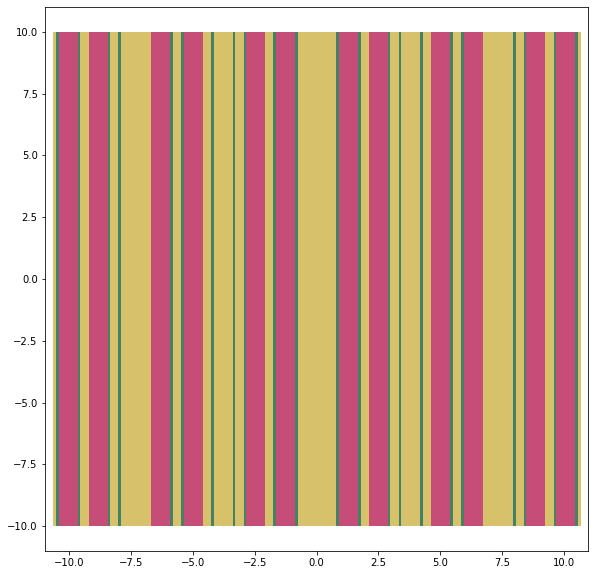

In [6]:
root_univ = model.geometry.root_universe

# axial image
root_univ.plot(width=(22.0, 22.0),
               pixels=(200, 300),
               basis='xz',
               color_by='material',
               seed=0)

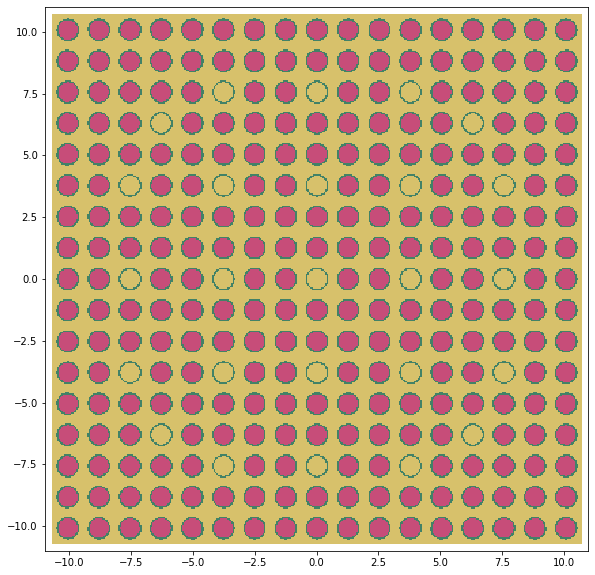

In [7]:
# radial image
root_univ.plot(width=(22.0, 22.0),
               pixels=(400, 400),
               basis='xy',
               color_by='material',
               seed=0)

Looks good! Let's run some particles through the problem.

In [8]:
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

0.20706788967181938+/-0.019653037754288005

Now it's time to apply our mesh tally to the problem. We'll be using the tetrahedral mesh "pins1-4.h5m" shown below:

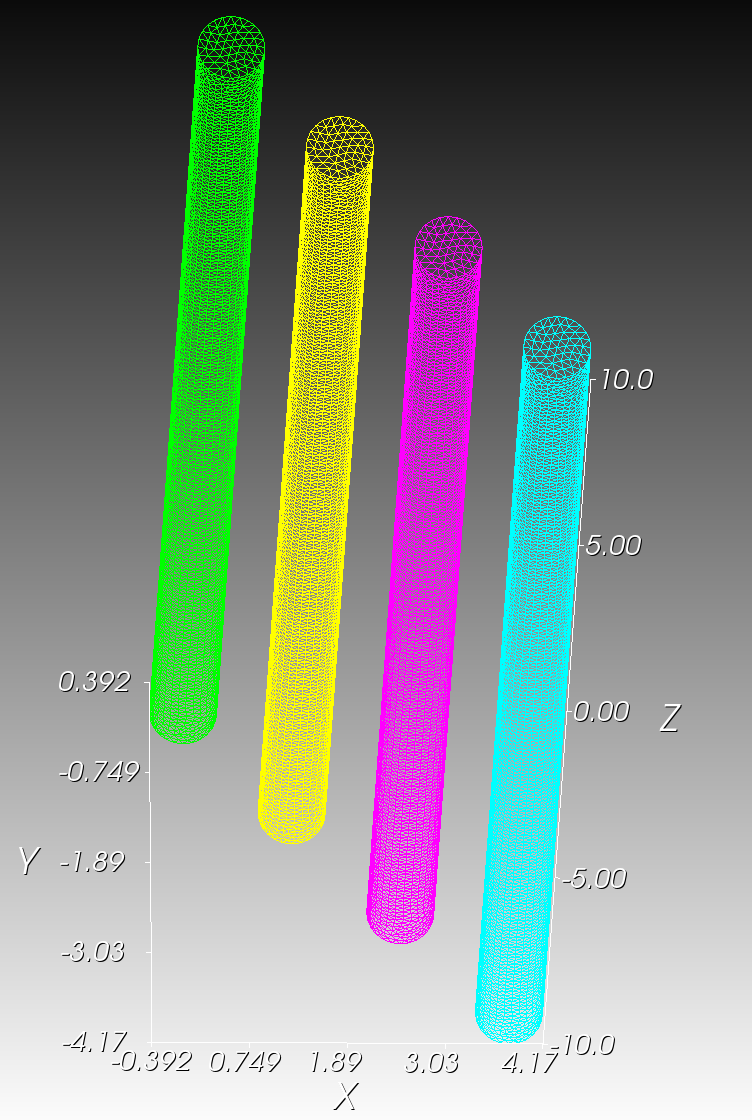

In [9]:
Image("./images/pin_mesh.png", width=600)

This mesh was generated using Trelis with radii that match the fuel/coolant channels of the PWR model. These four channels correspond to the highlighted channels of the assembly below.

Two of the channels are coolant and the other two are fuel.

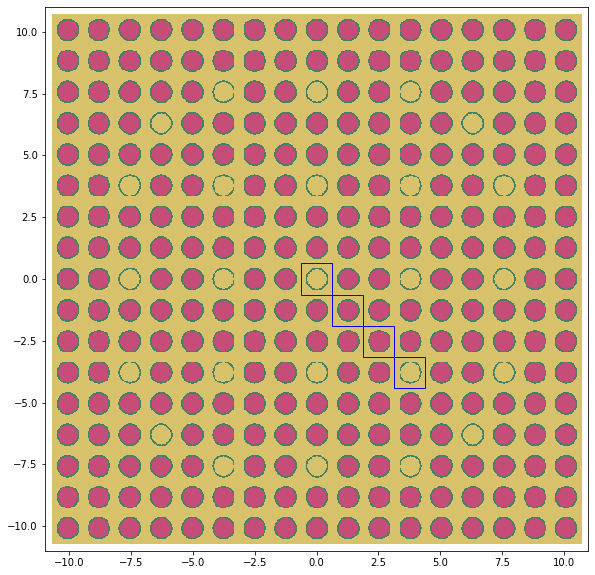

In [10]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

pitch = 1.26 # cm

img = root_univ.plot(width=(22.0, 22.0),
                           pixels=(600, 600),
                           basis='xy',
                           color_by='material',
                           seed=0)

# highlight channels
for i in range(0, 4):
    corner = (i * pitch - pitch / 2.0, -i * pitch - pitch / 2.0)
    rect = Rectangle(corner,
                     pitch,
                     pitch,
                     edgecolor='blue',
                     fill=False)
    img.axes.add_artist(rect)


### Applying an unstructured mesh tally

To use this mesh, we'll create an unstructured mesh instance and apply it to a mesh filter.

In [11]:
download(pin_mesh_url, "pins1-4.h5m")
umesh = openmc.UnstructuredMesh("pins1-4.h5m")
mesh_filter = openmc.MeshFilter(umesh)

We can now apply this filter like any other. For this demonstration we'll score both the flux and heating in these pins.

In [12]:
tally = openmc.Tally()
tally.filters = [mesh_filter]
tally.scores = ['heating', 'flux']
tally.estimator = 'tracklength'
model.tallies = [tally]

Now we'll run this model with the unstructured mesh tally applied. Notice that the simulation takes some time to start due to some additional data structures used by the unstructured mesh tally. Additionally, the particle rate drops dramatically during the active cycles of this simulation.

Unstructured meshes are useful, but they can be computationally expensive!

In [13]:
model.settings.particles = 100_000
model.settings.inactive = 20
model.settings.batches = 100
model.run(output=False)

0.2311872124292096+/-0.00017018932313754055

At the end of the simulation, we see the statepoint file along with a file named "tally_1.100.vtk". This file contains the results of the unstructured mesh tally with convenient labels for the scores applied. In our case the following scores will be present in the VTK:

  - flux_total_value
  - flux_total_std_dev
  - heating_total_value
  - heading_total_std_dev
  
  Where "total" represents  
  

Currently, an unstructured VTK file will only be generated for tallies if the unstructured mesh is is the only filter applied to that tally. All results for the unstructured mesh tally are present in the statepoint file regardless of the number of filters applied, however.

These files can be viewed using free tools like [Paraview](https://www.paraview.org/) and [VisIt](https://wci.llnl.gov/simulation/computer-codes/visit/) to examine the results.

In [14]:
!ls *.vtk

tally_1.100.vtk


## Flux

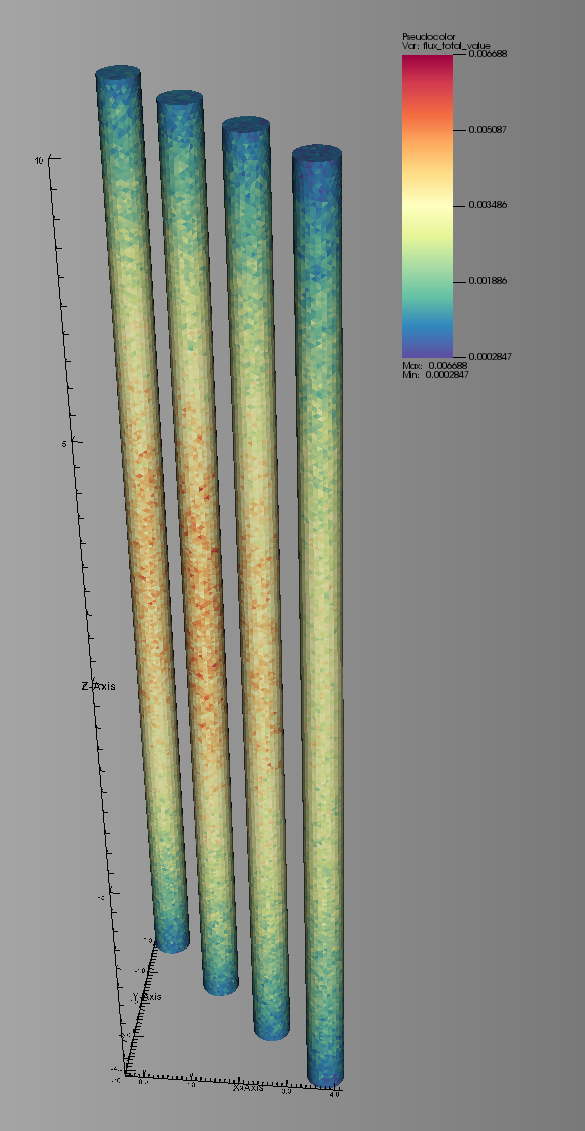

In [15]:
Image("./images/umesh_flux.png", width=600)

## Heating
Here is an image of the heating score as viewed in VisIt. Note that no heating is scored in the water-filled channels as expected.

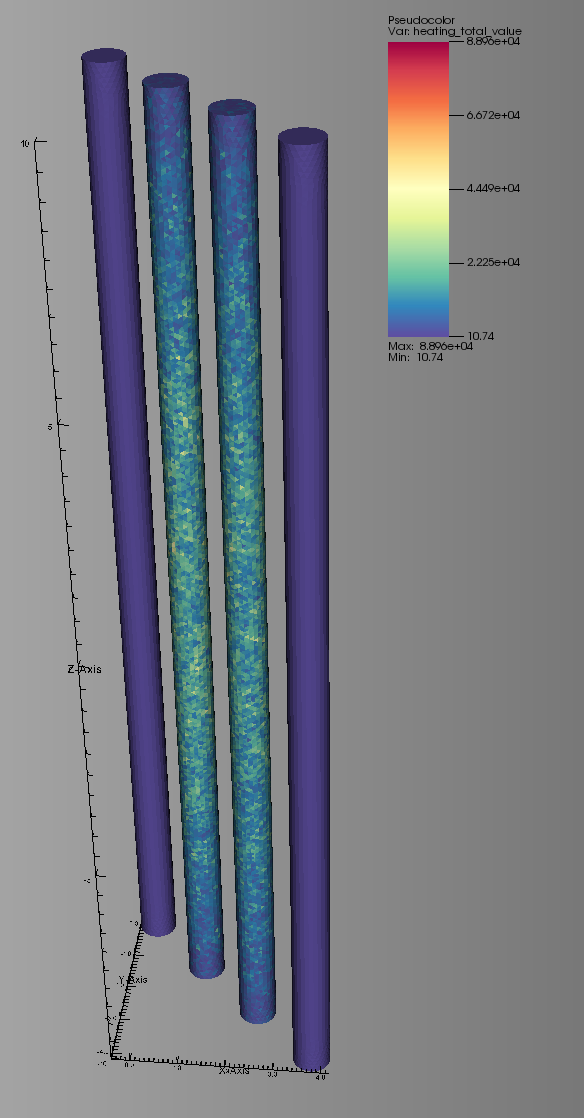

In [16]:
Image("./images/umesh_heating.png", width=600)

### Statepoint Data

In [17]:
with openmc.StatePoint("statepoint.100.h5") as sp:
    tally = sp.tallies[1]
    umesh = sp.meshes[1]

Enough information for visualization of results on the unstructured mesh is also provided in the statepoint file. Namely, the mesh element volumes and centroids are available.

In [18]:
print(umesh.volumes)
print(umesh.centroids)

[1.43381086e-04 1.48043747e-04 1.60408339e-04 ... 7.04197023e-05
 7.04197023e-05 7.04197023e-05]
[[ 2.88485691 -2.55429784  9.97768184]
 [ 2.87565092 -2.60469781  9.8884092 ]
 [ 2.85832254 -2.65291228  9.97768184]
 ...
 [ 1.46082175 -1.15569203 -3.62914358]
 [ 1.4443143  -1.1321793  -3.65475081]
 [ 1.46884412 -1.15657736 -3.68206543]]


The combination of these values can provide for an appoxmiate visualization of the unstructured mesh without its explicit representation or use of an additional mesh library.

We hope you've found this example notebook useful!

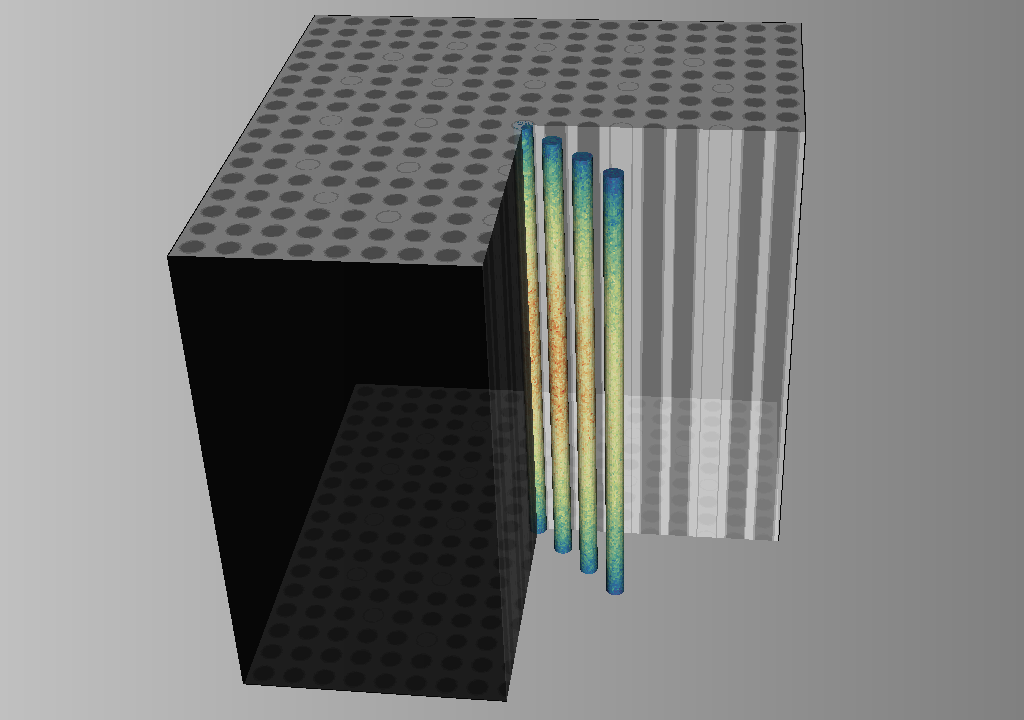

In [19]:
Image("./images/umesh_w_assembly.png", width=600)